In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Load data  
Note that `read_excel()` outputs a DataFrame: we keep this structure for further use.

In [2]:
losses = pd.read_excel('Data/losses.xlsx').set_index('Date').rename(columns={0:'loss'}) / 1e6
losses

,loss
Date,
2019-01-03,0.701146
2019-01-04,-1.205288
2019-01-07,-0.367580
2019-01-08,-0.279344
2019-01-09,-0.193142
...,...
2023-12-22,-0.219777
2023-12-26,-0.329805
2023-12-27,-0.710735


Set the confidence level $\alpha$ for Value-at-Risk computations

In [3]:
alpha = 0.95

# Age-weighted Value-at-Risk

Compute the age weights using a parameter $\lambda = 0.975$.
$$w_{t-i} = \frac{\lambda^{i-1}}{\Lambda} \qquad \Lambda = \sum_{i=0}^{n-1} \lambda^{i-1} = \frac{1-\lambda^n}{1-\lambda}$$

In [4]:
lam = 0.975
n = len(losses)

In [5]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
2 ** np.arange(10)

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

In [7]:
a = 5
a /= 10
a

0.5

In [9]:
weights = lam ** np.arange(n)
# weights = weights / weights.sum()
weights /= weights.sum()
weights

array([2.50000000e-02, 2.43750000e-02, 2.37656250e-02, ...,
       3.96947170e-16, 3.87023491e-16, 3.77347904e-16])

In [10]:
weights.sum()

1.0000000000000002

The largest weight must be associated to the most recent value. The order of the array must be reversed.  
We use [`numpy` **slicing**](https://numpy.org/doc/stable/user/basics.indexing.html#slicing-and-striding).

In [11]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
a[:5]

array([0, 1, 2, 3, 4])

In [13]:
a[5:]

array([5, 6, 7, 8, 9])

In [14]:
a[3:7]

array([3, 4, 5, 6])

In [15]:
a[3:7:2]

array([3, 5])

In [16]:
a[::2]

array([0, 2, 4, 6, 8])

In [17]:
a[::3]

array([0, 3, 6, 9])

In [18]:
a[-2:]

array([8, 9])

In [19]:
a[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

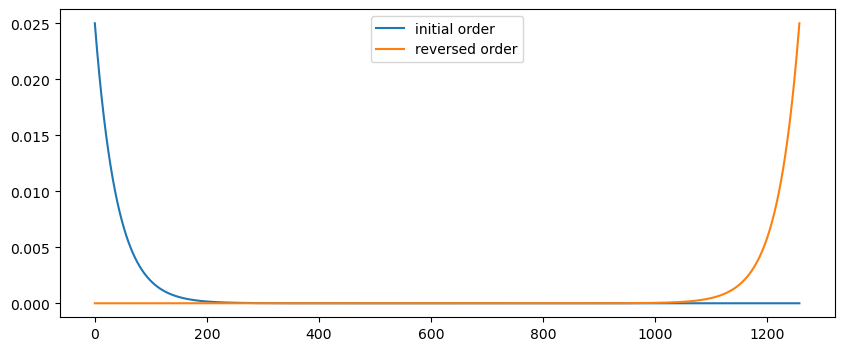

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(weights, label="initial order")
ax.plot(weights[::-1], label="reversed order")
lgd = ax.legend()

Add a colum `'age_weight'` to the DataFrame `losses`

In [21]:
losses.head()

,loss
Date,
2019-01-03,0.701146
2019-01-04,-1.205288
2019-01-07,-0.367580
2019-01-08,-0.279344
2019-01-09,-0.193142


In [22]:
losses['age_weight'] = weights[::-1]
losses.head()

,loss,age_weight
Date,,
2019-01-03,0.701146,3.773479e-16
2019-01-04,-1.205288,3.870235e-16
2019-01-07,-0.367580,3.969472e-16
2019-01-08,-0.279344,4.071253e-16
2019-01-09,-0.193142,4.175644e-16


In [23]:
losses.tail()

,loss,age_weight
Date,,
2023-12-22,-0.219777,0.022592
2023-12-26,-0.329805,0.023171
2023-12-27,-0.710735,0.023766
2023-12-28,0.268532,0.024375
2023-12-29,0.282610,0.025000


Sort the DataFrame by **descending** `loss` values. See [`DataFrame.sort_values()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)

In [24]:
losses.sort_values(by='loss', ascending=False, inplace=True)
losses.head()

,loss,age_weight
Date,,
2020-03-12,5.826666,7.317485e-13
2020-03-16,4.838571,7.697552e-13
2020-03-18,3.237599,8.097359e-13
2022-06-13,3.041510,1.287479e-06
2020-03-23,2.945105,8.736340e-13


Add the [cumulative sum](https://pandas.pydata.org/docs/reference/api/pandas.Series.cumsum.html) of the age weights

In [25]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:
np.cumsum(a)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [27]:
losses['sum_age_weights'] = losses['age_weight'].cumsum()
losses.head()

,loss,age_weight,sum_age_weights
Date,,,
2020-03-12,5.826666,7.317485e-13,7.317485e-13
2020-03-16,4.838571,7.697552e-13,1.501504e-12
2020-03-18,3.237599,8.097359e-13,2.311240e-12
2022-06-13,3.041510,1.287479e-06,1.287481e-06
2020-03-23,2.945105,8.736340e-13,1.287482e-06


Find the point where the sum of the age weights is greater than $1-\alpha$.

In [28]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [29]:
a >= 5

array([False, False, False, False, False,  True,  True,  True,  True,
        True])

In [30]:
a[a >= 5]

array([5, 6, 7, 8, 9])

In [31]:
(a >= 3) & (a <=7)

array([False, False, False,  True,  True,  True,  True,  True, False,
       False])

In [32]:
a[(a >= 3) & (a <=7)]

array([3, 4, 5, 6, 7])

In [33]:
a[(a <= 3) | (a > 7)]

array([0, 1, 2, 3, 8, 9])

In [34]:
losses[(losses['sum_age_weights'] > 0.048) & (losses['sum_age_weights'] < 0.052)]

,loss,age_weight,sum_age_weights
Date,,,
2023-07-06,0.815295,1.082711e-03,0.049046
2022-09-21,0.813908,7.386210e-06,0.049053
2020-04-20,0.813522,1.413324e-12,0.049053
2023-08-15,0.809390,2.199800e-03,0.051253
2019-12-02,0.807644,1.275500e-13,0.051253


In [35]:
losses.loc['2020', ['loss', 'sum_age_weights']]

,loss,sum_age_weights
Date,,
2020-03-12,5.826666,7.317485e-13
2020-03-16,4.838571,1.501504e-12
2020-03-18,3.237599,2.311240e-12
2020-03-23,2.945105,1.287482e-06
2020-03-09,2.614186,1.287483e-06
...,...,...
2020-03-02,-2.439843,9.999816e-01
2020-03-26,-3.139109,9.999816e-01
2020-03-13,-3.285926,9.999816e-01


In [36]:
VaR_age_weight = losses.loc['2020-04-20', 'loss']
print(f"The age-weighted VaR at {alpha:.1%} confidence level is {VaR_age_weight:.3f} m€")

The age-weighted VaR at 95.0% confidence level is 0.814 m€


# Volatility weighted

We now load the portfolio returns

In [37]:
returns = pd.read_excel('Data/portf_returns.xlsx').set_index('Date').rename(columns={0: 'ret'})
returns.head()

,ret
Date,
2019-01-03,-0.007011
2019-01-04,0.012053
2019-01-07,0.003676
2019-01-08,0.002793
2019-01-09,0.001931


## Using rolling volatility

Compute the [rolling standard deviation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) over a window of 65 business days and save as a new column.

In [38]:
window = 65
returns['rolling_std'] = returns['ret'].rolling(window).std()
returns

,ret,rolling_std
Date,,
2019-01-03,-0.007011,NaN
2019-01-04,0.012053,NaN
2019-01-07,0.003676,NaN
2019-01-08,0.002793,NaN
2019-01-09,0.001931,NaN
...,...,...
2023-12-22,0.002198,0.006159
2023-12-26,0.003298,0.006126
2023-12-27,0.007107,0.005989


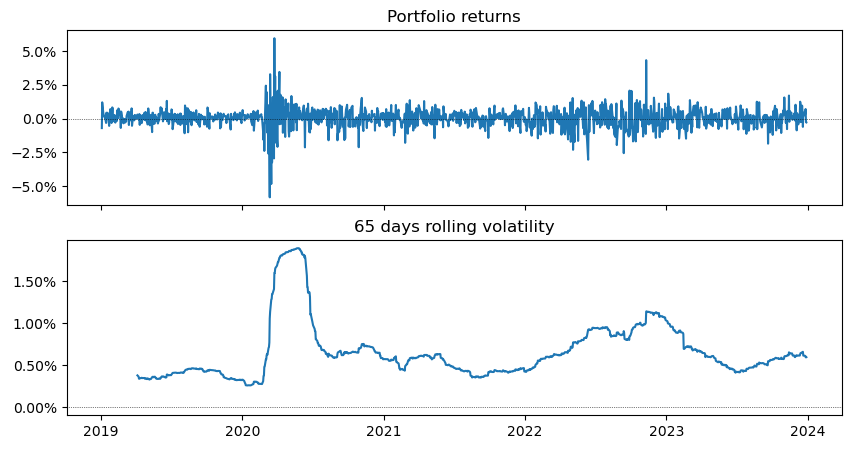

In [39]:
col_names = ['ret', 'rolling_std']
labels = ["Portfolio returns", f"{window} days rolling volatility"]

fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
for ax, name, label in zip(axs, col_names, labels):
    ax.plot(returns[name])
    ax.set_title(label)
    ax.axhline(0, c='k', ls=':', lw=.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


Scale the returns with volatility and save as a new column
$$x^{\mathrm{vol\,weighted\,hist}}_t = \frac{\sigma(T)}{\sigma(t)} x^{\mathrm{hist}}_t$$

In [40]:
returns['rolling_std'].iloc[-1]

0.0059736329018587764

In [41]:
returns['ret_vol_weighted'] = returns['ret'] / returns['rolling_std'] * returns['rolling_std'].iloc[-1]
returns.tail()

,ret,rolling_std,ret_vol_weighted
Date,,,
2023-12-22,0.002198,0.006159,0.002132
2023-12-26,0.003298,0.006126,0.003216
2023-12-27,0.007107,0.005989,0.007089
2023-12-28,-0.002685,0.005947,-0.002697
2023-12-29,-0.002826,0.005974,-0.002826


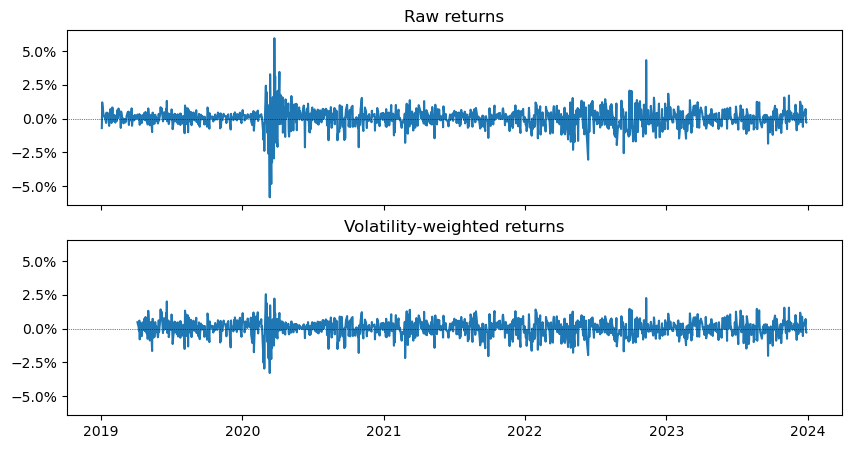

In [42]:
col_names = ['ret', 'ret_vol_weighted']
labels = ["Raw returns", "Volatility-weighted returns"]

fig, axs = plt.subplots(2, figsize=(10,5), sharex=True, sharey=True)
for ax, name, label in zip(axs, col_names, labels):
    ax.plot(returns[name])
    ax.set_title(label)
    ax.axhline(0, c='k', ls=':', lw=.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


Save the vol-weighted losses as a new column

In [43]:
returns['loss_vol_weighted'] = -1e2 * returns['ret_vol_weighted']
returns.tail()

,ret,rolling_std,ret_vol_weighted,loss_vol_weighted
Date,,,,
2023-12-22,0.002198,0.006159,0.002132,-0.213155
2023-12-26,0.003298,0.006126,0.003216,-0.321601
2023-12-27,0.007107,0.005989,0.007089,-0.708879
2023-12-28,-0.002685,0.005947,-0.002697,0.269714
2023-12-29,-0.002826,0.005974,-0.002826,0.282610


Extract the losses, drop the NaN values and sort

In [44]:
losses = returns['loss_vol_weighted'].dropna().sort_values()
losses.tail()

Date
2020-03-09    2.207167
2020-03-16    2.250195
2020-02-25    2.529218
2020-02-27    2.958690
2020-03-12    3.288282
Name: loss_vol_weighted, dtype: float64

Find the position of the quantile and compute the vol-weighted VaR.

In [45]:
len(losses)

1194

In [46]:
quantile_pos = int(alpha * len(losses))
quantile_pos

1134

In [47]:
VaR_vol_weight = losses.iloc[quantile_pos]
print(f"The volatility-weighted VaR at {alpha:.1%} confidence level is {VaR_vol_weight:.3f} m€")

The volatility-weighted VaR at 95.0% confidence level is 1.029 m€


## Using EWMA volatility

We compute EWMA with the RiskMetrics parameter $\lambda = 0.94$, that is a 6% weight on the last observation.  

Note that the parameter in `pandas`' method is $\alpha = 1-\lambda$. See the following links:
- [Exponentially weighted window](https://pandas.pydata.org/docs/user_guide/window.html#window-exponentially-weighted)  
- [`pandas.DataFrame.ewm`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html)

Compute the EWMA standard deviation and save as a new column.  

In [48]:
lam = 0.94
print(type(returns['ret']))
returns['EWMA_vol'] = returns['ret'].ewm(alpha=1-lam).std()
returns

<class 'pandas.core.series.Series'>


,ret,rolling_std,ret_vol_weighted,loss_vol_weighted,EWMA_vol
Date,,,,,
2019-01-03,-0.007011,NaN,NaN,NaN,NaN
2019-01-04,0.012053,NaN,NaN,NaN,0.013481
2019-01-07,0.003676,NaN,NaN,NaN,0.009397
2019-01-08,0.002793,NaN,NaN,NaN,0.007554
2019-01-09,0.001931,NaN,NaN,NaN,0.006458
...,...,...,...,...,...
2023-12-22,0.002198,0.006159,0.002132,-0.213155,0.005697
2023-12-26,0.003298,0.006126,0.003216,-0.321601,0.005527
2023-12-27,0.007107,0.005989,0.007089,-0.708879,0.005474


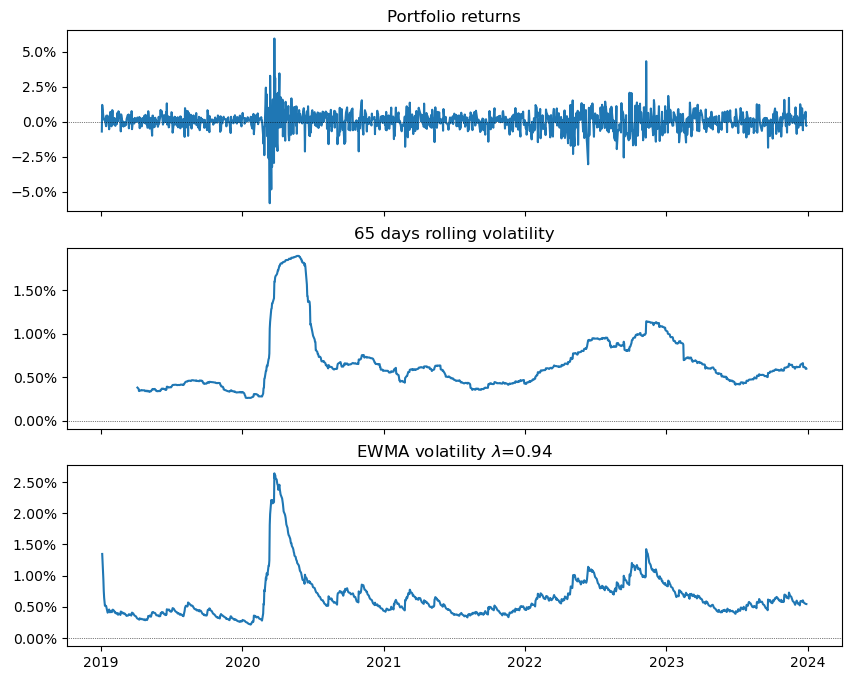

In [49]:
col_names = ['ret', 'rolling_std', 'EWMA_vol']
labels = ["Portfolio returns",
          f"{window} days rolling volatility",
          f"EWMA volatility $\lambda$={lam}"]
          
fig, axs = plt.subplots(3, figsize=(10,8), sharex=True)
for ax, name, label in zip(axs, col_names, labels):
    ax.plot(returns[name])
    ax.set_title(label)
    ax.axhline(0, c='k', ls=':', lw=.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


Scale the returns with EWMA volatility and save as a new column

In [50]:
returns['ret_EWMA_weighted'] = returns['ret'] / returns['EWMA_vol'] * returns['EWMA_vol'].iloc[-1]
returns.tail()

,ret,rolling_std,ret_vol_weighted,loss_vol_weighted,EWMA_vol,ret_EWMA_weighted
Date,,,,,,
2023-12-22,0.002198,0.006159,0.002132,-0.213155,0.005697,0.002103
2023-12-26,0.003298,0.006126,0.003216,-0.321601,0.005527,0.003252
2023-12-27,0.007107,0.005989,0.007089,-0.708879,0.005474,0.007076
2023-12-28,-0.002685,0.005947,-0.002697,0.269714,0.005467,-0.002677
2023-12-29,-0.002826,0.005974,-0.002826,0.282610,0.005450,-0.002826


In [51]:
returns['EWMA_vol'].iloc[-1]

0.005450332604655505

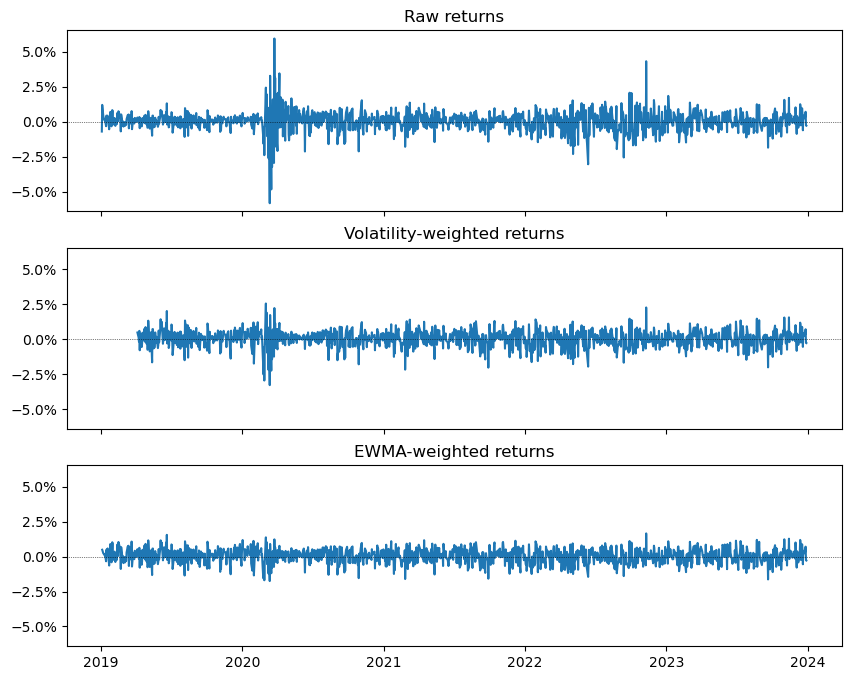

In [52]:
col_names = ['ret', 'ret_vol_weighted', 'ret_EWMA_weighted']
labels = ["Raw returns",
          "Volatility-weighted returns",
          "EWMA-weighted returns"]
          
fig, axs = plt.subplots(3, figsize=(10,8), sharex=True, sharey=True)
for ax, name, label in zip(axs, col_names, labels):
    ax.plot(returns[name])
    ax.set_title(label)
    ax.axhline(0, c='k', ls=':', lw=.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


Save the EWMA-weighted losses as a new column

In [53]:
returns['loss_EWMA_weighted'] = -1e2 * returns['ret_EWMA_weighted']
returns.tail()

,ret,rolling_std,ret_vol_weighted,loss_vol_weighted,EWMA_vol,ret_EWMA_weighted,loss_EWMA_weighted
Date,,,,,,,
2023-12-22,0.002198,0.006159,0.002132,-0.213155,0.005697,0.002103,-0.210260
2023-12-26,0.003298,0.006126,0.003216,-0.321601,0.005527,0.003252,-0.325201
2023-12-27,0.007107,0.005989,0.007089,-0.708879,0.005474,0.007076,-0.707630
2023-12-28,-0.002685,0.005947,-0.002697,0.269714,0.005467,-0.002677,0.267695
2023-12-29,-0.002826,0.005974,-0.002826,0.282610,0.005450,-0.002826,0.282610


Extract the losses, drop the NaN values and sort

In [58]:
losses = returns['loss_EWMA_weighted'].dropna().sort_values()
losses

Date
2022-11-10   -1.654955
2019-06-20   -1.552942
2020-03-02   -1.373137
2023-11-14   -1.276621
2023-11-02   -1.232905
                ...   
2021-09-28    1.581311
2021-02-25    1.606371
2023-09-21    1.634897
2020-02-27    1.694550
2020-03-12    1.751573
Name: loss_EWMA_weighted, Length: 1257, dtype: float64

Find the position of the quantile and compute the vol-weighted VaR.

In [55]:
quantile_pos = int(alpha * len(losses))
quantile_pos

1194

In [56]:
VaR_EWMA_weight = losses.iloc[quantile_pos]
print(f"The EWMA-weighted VaR at {alpha:.1%} confidence level is {VaR_EWMA_weight:.3f} m€")

The EWMA-weighted VaR at 95.0% confidence level is 0.875 m€
